In [1]:
# For user-defined post processing and plotting functions
import sys
sys.path.insert(0, "../../..")
from utils.plot_utils_v2 import *

Welcome to the "how to" of Markov Chain Monte Carlo using PYMC. A python software package allowing you to fit complex models with ease. 

## Case Study 1: Exponential Growth

We are going to establish an exponential model in this case study. The ODE and it's solution will be defined in the near future.  

First things first. Data! Pandas is the defacto python package for reading in data. It's also smart to handle any necessary data conversions during this step. Our data spans many magnitudes, so we will go ahead and perform our log conversion now. You may not need to and that's just fine! It all depends on what you are looking for.

Note: The "+ 1e-9" is merely a fail-safe against divide-by-zero errors when doing a log transform. Adding a value infitesimally near 0 makes no impact on the data itself and prevents the aformentioned error. Good quick trick to know!

In [2]:
## Cell 1 ##

import pandas as pd
import numpy as np

data = pd.read_csv("../../../case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values
log_obs = np.log(obs + 1e-9)

First things first, the ODE system. We will setup the logistic ODE that will adapt to the data. To do this, you will use variables that PyMC gives you by 'default'. Let me explain. Note that in Cell 2 there are 3 parameters being passed in (y, t, params). You will also not see these variables being explicitly passed in this way anywhere. Here is what happens. When you create the ODE function in Cell 2, it gets passed to the the 'cell_model' in Cell 3. Now look to where the 'cell_model' is called in cell 4. There it passes priors into Y0 and theta. The connection is Y0 goes to y, and theta goes to params. The order you hand over the priors matters so call them in the correct order when creating the ODE equation. Never forget to be mindful of your prior's orientations when you pass them!

**mum**: Growth Rate  
**y**: Initial Value

$$
\frac{dy}{dt} = \mu y
$$

In [3]:
## Cell 2 ##

def ode(y, t, params):
    mum = params[0]
    return [mum * y[0]]

Here is the model we spoke about earlier. Here is what goes into each variable.

**func**: the ODE function you just created  
**times**: the time steps from your data  
**n_states**: possible states count  
**n_theta**: Unique parameter count  
**t0**: inital time step (should almost always be 0)

In [4]:
## Cell 3 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=1,
    t0=0
)

This is where we create the MCMC 'loop': Sample Priors -> Estimate ODE @ times -> check fit

First, priors. You have all kinds of options. Uniform, normal, lognormal, halfnormal. It all depends on what you need. For $\mu$ we chose a truncated normal prior. This says, "we believe there is a normal distribution about some **x**, however, it cannot be below some **y** or above some **z**". For **N0**, we chose a lognormal distribution. This says, "we believe our value is around some **x** given a normalesque strictly positive distribution". For **sigma**, we chose a halfnormal distribution. This is usually used for your error or standard deviation. This is usually used for your error or standard deviation since neither can be negative and you can tune how quickly it tails off. Below are the priors visualized.  

<img src="../../figures/priors_c1p1.png" width="300"/>

After the priors are declared the next function call will be for the solution of the model given its current estimates. We spoke about how to pass the priors in previously. Be careful during this step!

The final function is for the likelihood estimation. This is where the model tests how well it estimated the observed data. We pass it our log transformed estimated data, the sigma value from the iteration's sample, and log transformed observed data. Now just let PyMC work its magic!

In [ ]:
## Cell 4 ##

with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=log_obs[0], sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    sol = cell_model(y0=[N0], theta=[mum])

    pm.Normal("Y_obs", 
              mu=pm.math.log(sol[:, 0] + 1e-9), 
              sigma=sigma, 
              observed=log_obs)

This is how you call and run the model!

**draws**: poterior values to be generated.  
**tune**: Some under the hood PyMC magic that 'warms it up'. Keep this between 500 and 2000 depending on how complex your model is.  
**chains / cores**: Amount of chains you want to compute in parallel. Keep these values the same for most basic usage. PyMC recommends you run at least 4 chains.  
**return_inferencedata**: returns an ARVIZ inferencedata object which we'll use for easy reading of our output.  
**target_accept**: the % of times you accept the improved likelihood at each step of the chain. This is your exploration vs exploitation balance. 

In [ ]:
## CELL 5 ##

with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      chains=4, 
                      cores=4,
                      return_inferencedata=True,
                      target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mum, N0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 39 seconds.


To interpret the output we have some user-defined postprocessing and plotting functions. They are in our GitHub repo.

Sampling: [N0, Y_obs, mum, sigma]


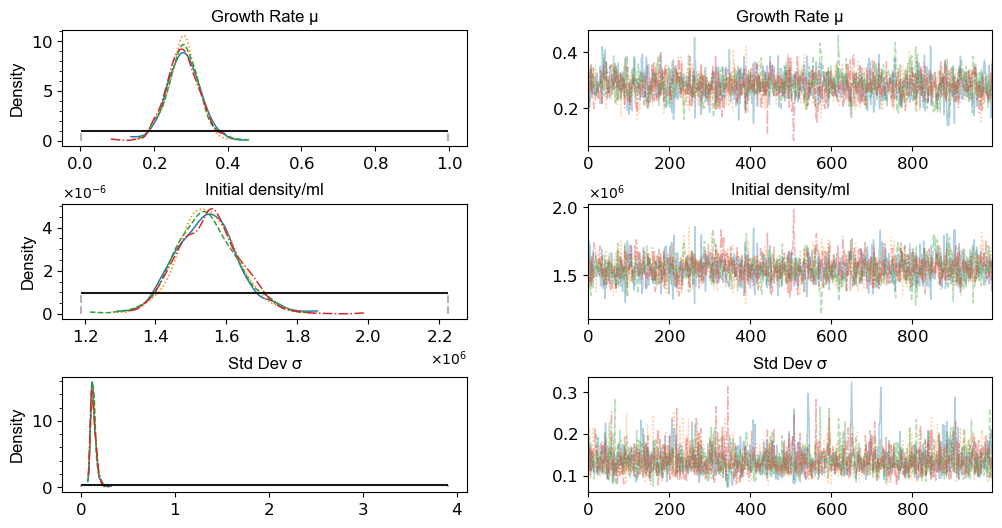

array([[<Axes: title={'center': 'Growth Rate μ'}, ylabel='Density'>,
        <Axes: title={'center': 'Growth Rate μ'}>],
       [<Axes: title={'center': 'Initial density/ml'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial density/ml'}>],
       [<Axes: title={'center': 'Std Dev σ'}, ylabel='Density'>,
        <Axes: title={'center': 'Std Dev σ'}>]], dtype=object)

In [7]:
plot_trace(trace=trace,
           model=model,
           var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ', 'sigma': 'Std Dev σ'},
           var_order=['mum','N0','sigma'],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=2000,
           save_path='figures/normal_growth_chains.png')

Now we interpret the results. Remember the ODE's from before.

$$
\frac{dy}{dt} = \mu y
$$

Take note of x-axis values at the peaks of the PDFs and the variables they represent. The x-axis values at those peaks are what the model found to be the optimal value for the equation. The right hand column is a frequency plot. This is just to make sure the model is exploring the parameter space well enough. 

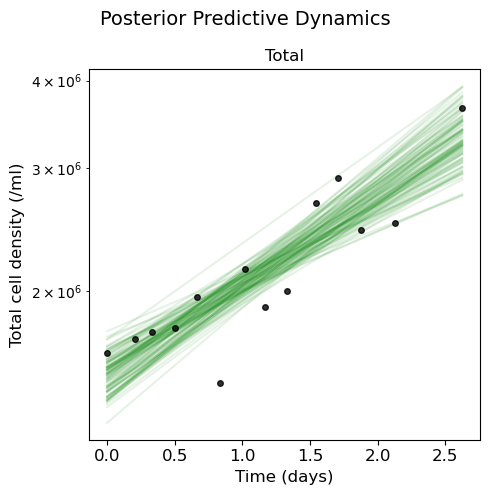

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [8]:
dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}

def ode_solution2data(solution):
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(dataset=dataset_postprocessing,
                   trace=trace,
                   model=model,
                   n_plots=100,
                   burn_in=50,
                   num_variables=1,
                   ode_fn=ode,
                   ode2data_fn=ode_solution2data,
                   save_path="figures/vardi_logistic_growth_dynamics.png",
                   # the key of this dict is the variable name in the dataset_postprocessing
                   var_properties={
                       "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
                  },
                   suptitle="Posterior Predictive Dynamics",
                   color_lines='green')

This plot is showing how well the range of estimated chains fit the observed data.

**CONGRATULATIONS!** you just ran you first MCMC!

## Case Study 1: Exponential Growth and Death

Now on to a more complex model. We will be using the same data as before.


In [9]:
## Cell 6 ##

import pandas as pd
import numpy as np
data = pd.read_csv("../../../case_study_1/python/data/phaeocystis_control.csv")
time = data['times'].values
obs = data['cells'].values
log_obs = np.log(obs + 1e-9)

$$
\frac{dy}{dt} = (\mu - \delta)\, y
$$

Here we are simply subtracting a **delta** from **mu** so that **delta** can simulate death. In short, we don't always need death (or something else comperable) data. We can simply make our ODE expressive about the data!

In [10]:
## Cell 7 ##

def ode(y, t, params):
    mum,delta = params[0],params[1]
    return [(mum-delta) * y[0]]

Here we have our new model setup. We have two unique parameters (mum, delta) so we'll set **n_theta** to 2.

In [11]:
## Cell 8 ##

import pymc as pm
cell_model = pm.ode.DifferentialEquation(
    func=ode,
    times=data['times'].values,
    n_states=1,
    n_theta=2,
    t0=0
)

Here is the model. Everything here should make sense. If something is confusing see the explination above cell 4. Still note that we have two likelihoods at the bottom since we are estimating two states.

In [ ]:
## Cell 9 ##

import numpy as np
with pm.Model() as model:
    mum = pm.TruncatedNormal('mum', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    delta = pm.TruncatedNormal('delta', mu=0.5, sigma=0.3, lower=0.0, upper=1.0)
    N0 = pm.Lognormal('N0', mu=log_obs[0], sigma=0.1)
    sigma = pm.HalfNormal("sigma", 1)

    sol = cell_model(y0=[N0], theta=[mum, delta])

    pm.Normal("Y_obs", 
              mu=pm.math.log(sol[:, 0] + 1e-9), 
              sigma=sigma, 
              observed=log_obs)

Everything here is the same as before! See explination above cell 5 if you forgot something.

In [ ]:
## Cell 10 ##

with model:
    trace = pm.sample(draws=1000, 
                      tune=1000, 
                      chains=4, 
                      cores=4,
                      return_inferencedata=True,
                      target_accept=0.95)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mum, delta, N0, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 120 seconds.


Sampling: [N0, Y_obs, delta, mum, sigma]


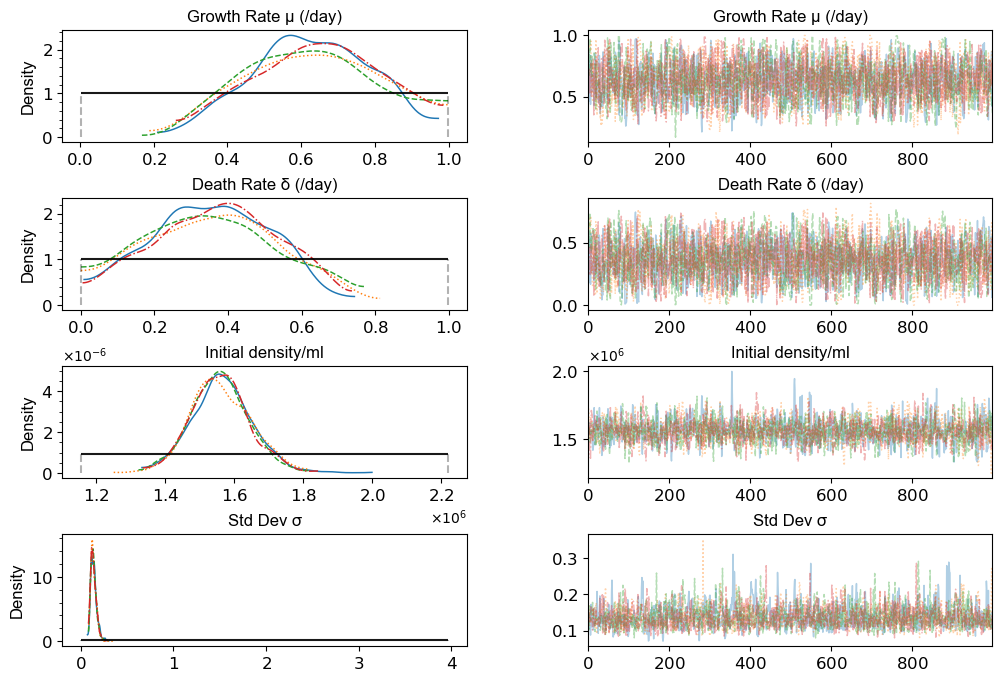

array([[<Axes: title={'center': 'Growth Rate μ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Growth Rate μ (/day)'}>],
       [<Axes: title={'center': 'Death Rate δ (/day)'}, ylabel='Density'>,
        <Axes: title={'center': 'Death Rate δ (/day)'}>],
       [<Axes: title={'center': 'Initial density/ml'}, ylabel='Density'>,
        <Axes: title={'center': 'Initial density/ml'}>],
       [<Axes: title={'center': 'Std Dev σ'}, ylabel='Density'>,
        <Axes: title={'center': 'Std Dev σ'}>]], dtype=object)

In [14]:
plot_trace(trace=trace,
           model=model,
           var_names_map={'N0':'Initial density/ml','mum': 'Growth Rate μ (/day)', 'delta': 'Death Rate δ (/day)','sigma': 'Std Dev σ'},
           var_order=['mum','delta','N0','sigma'],
           fontname='Arial',
           fontsize=12,
           num_prior_samples=2000,
           save_path='figures/normal_growthdeath_chains.png')

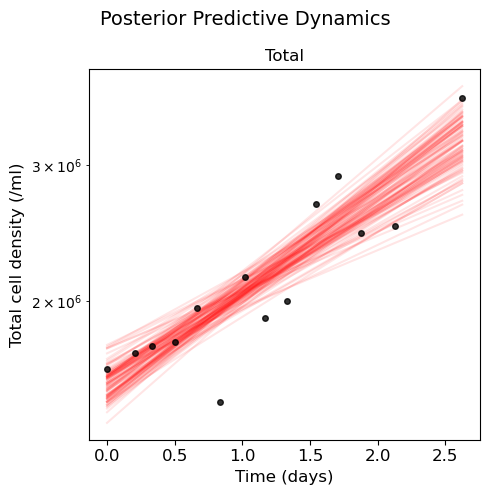

(<Figure size 500x500 with 1 Axes>,
 [<Axes: title={'center': 'Total'}, xlabel='Time (days)', ylabel='Total cell density (/ml)'>])

In [15]:
dataset_postprocessing = {
"Cells": [
        {"time": time, "values": obs},  # replicate 1
    ]
}

def ode_solution2data(solution):    
    total = solution[:, 0]  # Assuming the first column is the total cell count
    return {
        "total": total
    }

posterior_dynamics(dataset=dataset_postprocessing,
                   trace=trace,
                   model=model,
                   n_plots=100,
                   burn_in=50,
                   num_variables=1,
                   ode_fn=ode,
                   ode2data_fn=ode_solution2data,
                   save_path="figures/vardi_logistic_growthdeath_dynamics.png",
                   # the key of this dict is the variable name in the dataset_postprocessing
                   var_properties={
                       "Cells": {"label": "Total", "color": "black", "ylabel": "Total cell density (/ml)", "xlabel":"Time (days)","sol_key": "total","log": True}
                   },
                   suptitle="Posterior Predictive Dynamics",
                   color_lines='red')